In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize, LogNorm
import colorcet as cc
import pytz
from datetime import datetime
from pathlib import Path

import rasterio
from rasterio.plot import show

In [2]:
df = pd.read_csv("michipicoten.csv")
dfz = pd.read_csv("michipicoten_zoom.csv")

In [3]:
df.head()

,Timestamp,Speed,Course,Latitude,Longitude,Source
0,2024-06-11 02:03:00,0.0,169,48.40961,-89.21642,Terr-AIS
1,2024-06-11 01:02:00,0.0,169,48.40962,-89.21646,Terr-AIS
2,2024-06-11 00:02:00,0.0,169,48.40959,-89.21644,Terr-AIS
3,2024-06-10 23:02:00,0.0,169,48.40962,-89.21645,Terr-AIS
4,2024-06-10 22:00:00,0.0,169,48.40963,-89.21644,Terr-AIS


In [4]:
df.Timestamp = pd.to_datetime(df.Timestamp)
dfz.Timestamp = pd.to_datetime(dfz.Timestamp)

In [5]:
fcols = ["Speed", "Course", "Latitude", "Longitude"]
df[fcols] = df[fcols].apply(lambda x: pd.to_numeric(x, errors="coerce"))
dfz[fcols] = dfz[fcols].apply(lambda x: pd.to_numeric(x, errors="coerce"))

In [6]:
df = df.dropna(subset="Speed")
dfz = dfz.dropna(subset="Speed")

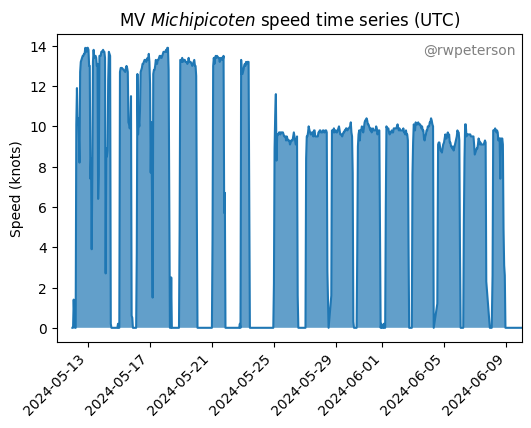

In [7]:
plt.figure(figsize=(6,4))

line_plot = sns.lineplot(df, x="Timestamp", y="Speed")
#plt.fill_between(df.Timestamp, df.Speed, alpha=0.8, step='mid')
# Extract the x and y data from the line plot
line_data = line_plot.get_lines()[0].get_data()
x_data = line_data[0]
y_data = line_data[1]

# Fill the area under the curve using the extracted data
plt.fill_between(x_data, y_data, alpha=0.7)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Speed (knots)")
plt.xlabel(None)
plt.xlim(datetime.fromisoformat('2024-05-11'),datetime.fromisoformat('2024-06-10'))
plt.title("MV $\\it{Michipicoten}$ speed time series (UTC)")

plt.text(0.89, 0.82, '@rwpeterson', fontsize=10, color='gray', 
         ha='right', va='bottom', transform=plt.gcf().transFigure)

plt.savefig('michipicoten_speed.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

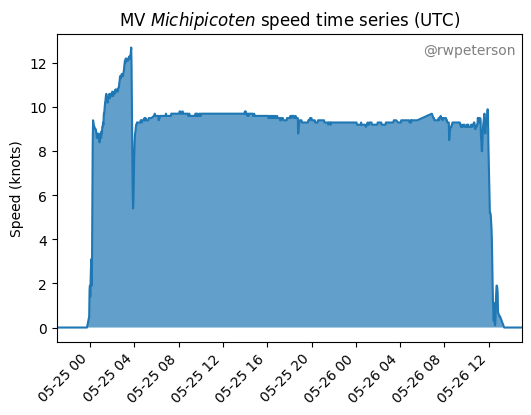

In [8]:
plt.figure(figsize=(6,4))

line_plot = sns.lineplot(dfz, x="Timestamp", y="Speed")
#plt.fill_between(df.Timestamp, df.Speed, alpha=0.8, step='mid')
# Extract the x and y data from the line plot
line_data = line_plot.get_lines()[0].get_data()
x_data = line_data[0]
y_data = line_data[1]

# Fill the area under the curve using the extracted data
plt.fill_between(x_data, y_data, alpha=0.7)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Speed (knots)")
plt.xlabel(None)
plt.xlim(datetime.fromisoformat('2024-05-24T21:00:00'),datetime.fromisoformat('2024-05-26T15:00:00'))
plt.title("MV $\\it{Michipicoten}$ speed time series (UTC)")

plt.text(0.89, 0.82, '@rwpeterson', fontsize=10, color='gray', 
         ha='right', va='bottom', transform=plt.gcf().transFigure)

plt.savefig('michipicoten_speed_zoom.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

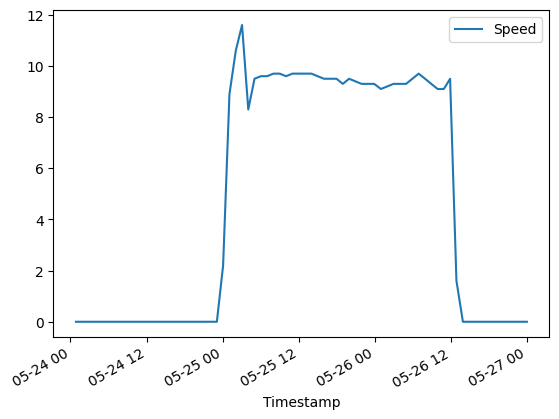

In [9]:
a = datetime.fromisoformat("2024-05-24")
b = datetime.fromisoformat("2024-05-27")
df.query("@a < Timestamp & Timestamp < @b").plot.line(x='Timestamp', y='Speed')
plt.show()

In [10]:
a = datetime.fromisoformat("2024-05-24T00:00:00")
b = datetime.fromisoformat("2024-05-27T06:00:00")
df.query("@a < Timestamp < @b")

,Timestamp,Speed,Course,Latitude,Longitude,Source
340,2024-05-27 05:51:00,10.0,290.0,46.82216,-85.09495,Terr-AIS
341,2024-05-27 04:52:00,9.7,328.0,46.73880,-84.90548,Terr-AIS
342,2024-05-27 03:52:00,9.5,320.0,46.60315,-84.78142,Terr-AIS
343,2024-05-27 02:53:00,9.5,317.0,46.49677,-84.60327,Terr-AIS
344,2024-05-27 01:54:00,8.4,232.0,46.48285,-84.44325,Terr-AIS
...,...,...,...,...,...,...
412,2024-05-24 04:56:00,0.0,0.0,46.70767,-92.04214,Terr-AIS
413,2024-05-24 03:54:00,0.0,0.0,46.70767,-92.04214,Terr-AIS
414,2024-05-24 02:53:00,0.0,0.0,46.70765,-92.04215,Terr-AIS
415,2024-05-24 01:53:00,0.0,0.0,46.70766,-92.04215,Terr-AIS


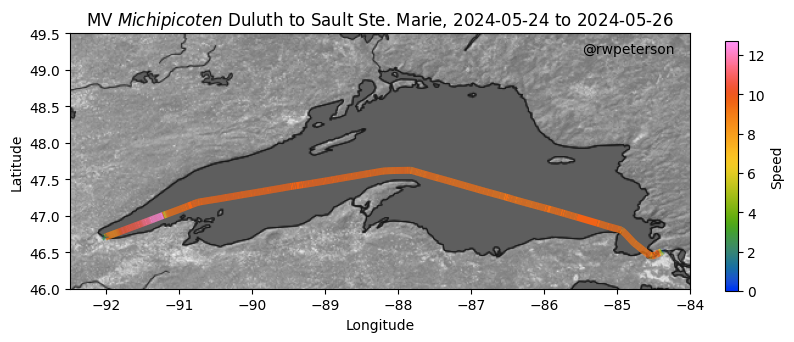

In [11]:
# Path to the raster file
raster_file_path = 'NE1_HR_LC_SR_W_DR.tif'

# Open the raster file
with rasterio.open(raster_file_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Read the first band

    # Get the affine transform (for plotting purposes)
    transform = src.transform

    # Plot the raster data
    fig, ax = plt.subplots(figsize=(10, 10))
    show(raster_data, transform=transform, ax=ax, cmap=cc.cm['CET_L1'])

    # Normalize the speed values and create a colormap
    norm = Normalize(vmin=dfz['Speed'].min(), vmax=dfz['Speed'].max())
    cmap = cc.cm.CET_R1
    colors = [cmap(norm(value)) for value in dfz['Speed']]

    # Create line segments between the points
    points = np.array([dfz['Longitude'], dfz['Latitude']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection with segments colored by the DataFrame column
    lc = LineCollection(segments, colors=colors, linewidths=5)
    ax.add_collection(lc)

    a = datetime.fromisoformat("2024-05-24T00:00:00")
    b = datetime.fromisoformat("2024-05-25T00:00:00")
    dfz2 = dfz.query("@a < Timestamp < @b")
    # Plot the latitude and longitude points
    #ax.scatter(dfz['Longitude'], dfz['Latitude'], c=dfz['Speed'], s=100, marker='o')


    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    # Add the colorbar to the plot
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Speed')
    
    # Adjust the colorbar size and position
    cbar.ax.set_position([0.78, 0.365, 0.03, 0.25])  # [left, bottom, width, height]
    
    # Add title and labels
    plt.title('MV $\\it{Michipicoten}$ Duluth to Sault Ste. Marie, 2024-05-24 to 2024-05-26')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.xlim([-92.5, -84])
    plt.ylim([46, 49.5])

    
    plt.text(0.73, 0.6, '@rwpeterson', fontsize=10, color='black', 
         ha='right', va='bottom', transform=plt.gcf().transFigure)

    
    plt.savefig('michipicoten_map_zoom.png', format='png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

In [12]:
devil = pd.read_csv('DISW3.txt', sep="\\s+", header=0)
devil = devil.iloc[1:]

In [13]:
devil.WVHT.unique()

array(['MM'], dtype=object)

In [14]:
mco = pd.read_csv("45028.spec", sep="\\s+", header=0)
mco = mco.iloc[1:]

In [15]:
mco.head()

,#YY,MM,DD,hh,mm,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,STEEPNESS,APD,MWD
1,2024,05,17,15,00,0.0,MM,MM,MM,MM,MM,MM,NaN,MM,0
2,2024,05,17,14,50,0.0,MM,MM,MM,MM,MM,MM,NaN,MM,0
3,2024,05,17,14,40,0.0,MM,MM,MM,MM,MM,MM,NaN,MM,0
4,2024,05,17,14,30,0.0,MM,MM,MM,MM,MM,MM,NaN,MM,0
5,2024,05,17,14,20,0.0,MM,MM,MM,MM,MM,MM,NaN,MM,0


In [16]:
mco.WVHT.unique()

array(['0.0'], dtype=object)

In [17]:
mcn = pd.read_csv("45027.txt", sep="\\s+", header=0)
mcn = mcn.iloc[1:]
mcn.rename(columns={"#YY": "YY"}, inplace=True)
mcn = mcn.apply(pd.to_numeric, errors='coerce')

In [18]:
mcn['Timestamp'] = mcn.apply(lambda r: datetime(*list(map(int,[r.YY, r.MM, r.DD, r.hh, r.mm]))), axis=1)

In [19]:
mcn.head()

,YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE,Timestamp
1,2024,6,11,22,10,60.0,6.0,NaN,0.4,2.0,NaN,92.0,1007.1,7.5,9.1,6.9,NaN,NaN,NaN,2024-06-11 22:10:00
2,2024,6,11,22,0,70.0,6.0,NaN,0.4,3.0,NaN,84.0,1007.1,7.6,9.1,7.0,NaN,-2.1,NaN,2024-06-11 22:00:00
3,2024,6,11,21,50,60.0,6.0,NaN,0.4,3.0,NaN,74.0,1007.3,7.6,9.1,7.0,NaN,NaN,NaN,2024-06-11 21:50:00
4,2024,6,11,21,40,50.0,5.0,NaN,0.4,3.0,NaN,59.0,1007.5,7.6,9.1,7.0,NaN,NaN,NaN,2024-06-11 21:40:00
5,2024,6,11,21,30,60.0,6.0,NaN,0.4,3.0,NaN,49.0,1007.7,7.6,9.1,7.0,NaN,NaN,NaN,2024-06-11 21:30:00


In [20]:
t0 = dfz.Timestamp.min()
t1 = dfz.Timestamp.max()

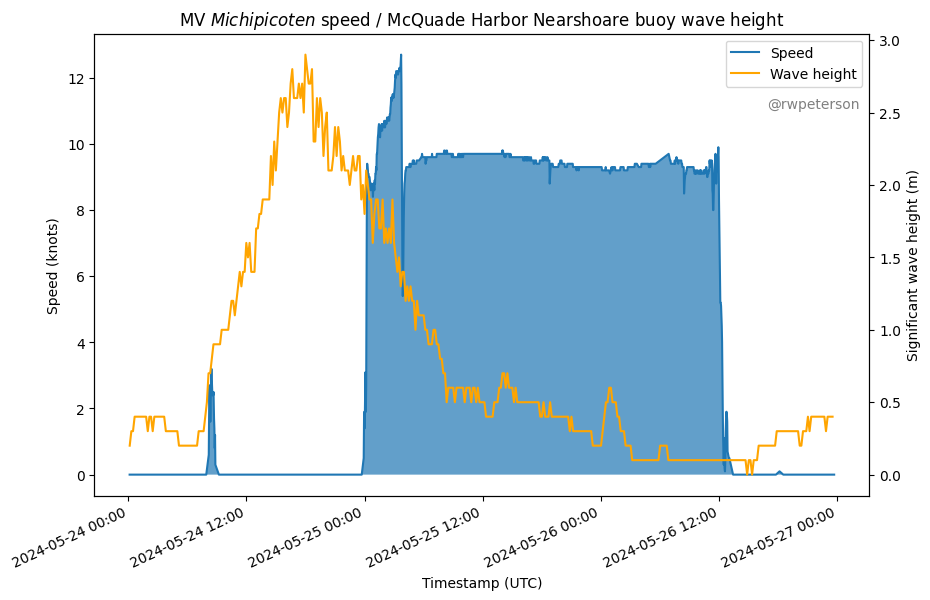

In [56]:
fig, ax1 = plt.subplots(figsize=(10, 6))

line_plot = sns.lineplot(
    dfz,
    x="Timestamp",
    y="Speed",
    label="Speed",
    legend=False,
    ax=ax1,
)
#plt.fill_between(df.Timestamp, df.Speed, alpha=0.8, step='mid')
# Extract the x and y data from the line plot
line_data = line_plot.get_lines()[0].get_data()
x_data = line_data[0]
y_data = line_data[1]

# Fill the area under the curve using the extracted data
plt.fill_between(x_data, y_data, alpha=0.7)


ax2 = ax1.twinx()

sns.lineplot(
    mcn.query("@t0 < Timestamp < @t1"),
    x="Timestamp",
    y="WVHT",
    #label="WVHT",
    color="orange",
    label="Wave height",
    legend=False,
    ax=ax2,
)

ax1.tick_params(axis='x', rotation=25)
for label in ax1.get_xticklabels():
    label.set_ha('right')
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m-%d %H:%M'))
ax1.set_ylabel("Speed (knots)")
ax1.set_xlabel("Timestamp (UTC)")
ax2.set_ylabel("Significant wave height (m)")

# Combine legends from both plots
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper right')

plt.xlabel(None)
#plt.xlim(datetime.fromisoformat('2024-05-24T21:00:00'),datetime.fromisoformat('2024-05-26T15:00:00'))
plt.title("MV $\\it{Michipicoten}$ speed / McQuade Harbor Nearshoare buoy wave height")

plt.text(
    0.89,
    0.75,
    '@rwpeterson',
    fontsize=10,
    color='gray', 
    ha='right',
    va='bottom',
    transform=plt.gcf().transFigure,
)

plt.savefig('michipicoten_zoom_wave.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

In [57]:
def read_ndbc_data(path):
    df = pd.read_csv(path, sep="\\s+", header=0)
    df = df.iloc[1:]  # Skip units row below header
    df.rename(columns={"#YY": "YY"}, inplace=True)  # Header is commented out
    
    # This is enough for realtime data: missing data is encoded as "MM" and coerced to NaN
    df = df.apply(pd.to_numeric, errors='coerce')
    # They switch from "MM" in realtime data to these sentinel values in historical data. 🤡
    df.replace([99.0, 999, 9999.0], np.nan, inplace=True)
    
    df['Timestamp'] = df.apply(lambda r: datetime(*list(map(int,[r.YY, r.MM, r.DD, r.hh, r.mm]))), axis=1)
    
    return df

In [58]:
mcn23 = read_ndbc_data("mcn_2023.txt")

In [91]:
mcn_d = []
for path in Path(".").glob("45027h*.txt"):
    mcn_d.append(read_ndbc_data(path))
mcn_d = pd.concat(mcn_d)

In [142]:
mcn_all = pd.concat([mcn_d, mcn]).reset_index()
mcn_all = mcn_all.query("YY >= 2021")

In [134]:
wls23 = read_ndbc_data("45028h2023.txt")

In [135]:
def plot_wvht(df, ylabel=None, title=None, filename=None, colorby=None):
    sns.histplot(
        df.WVHT,
        binwidth=0.1,
        binrange=(-0.05, df.WVHT.max() + 0.05),
        hue=colorby,
        multiple="stack",
    )
    plt.yscale('log')
    plt.xlabel("Significant wave height (m)")
    plt.ylabel(ylabel if ylabel else "Count")
    plt.title(title if title else "Seasonal significant wave height histogram (log axis)")
    if filename:
        plt.savefig(filename, format=filename.split(".")[-1], dpi=300, bbox_inches='tight')
    plt.show()

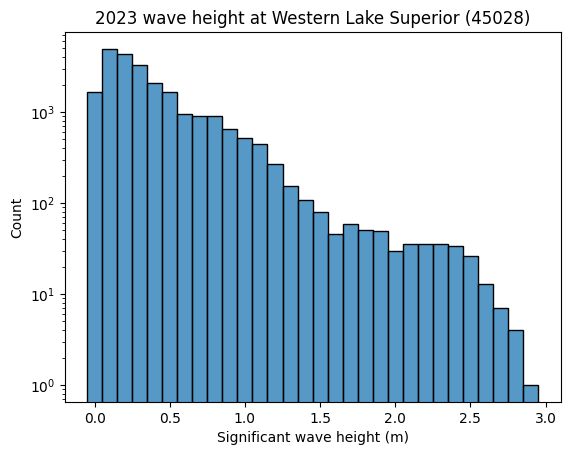

In [136]:
plot_wvht(wls23, title="2023 wave height at Western Lake Superior (45028)", filename="wls_waves.png")

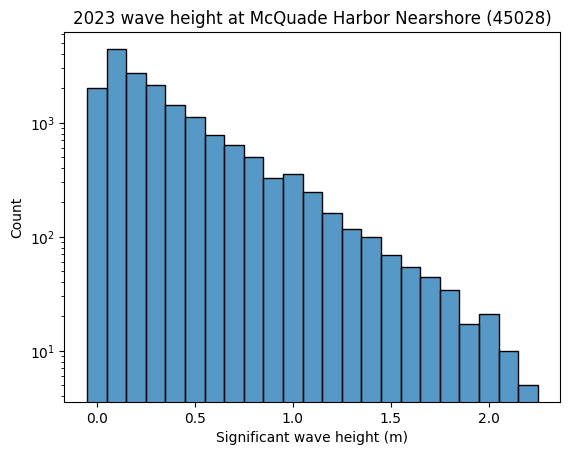

In [137]:
plot_wvht(mcn23, title="2023 wave height at McQuade Harbor Nearshore (45028)", filename="mcn_waves.png")

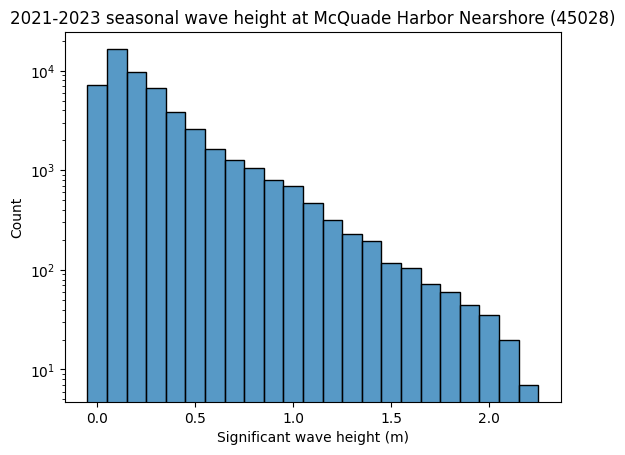

In [138]:
plot_wvht(mcn_d, title="2021-2023 seasonal wave height at McQuade Harbor Nearshore (45028)", filename="mcn_waves_21-23.png")

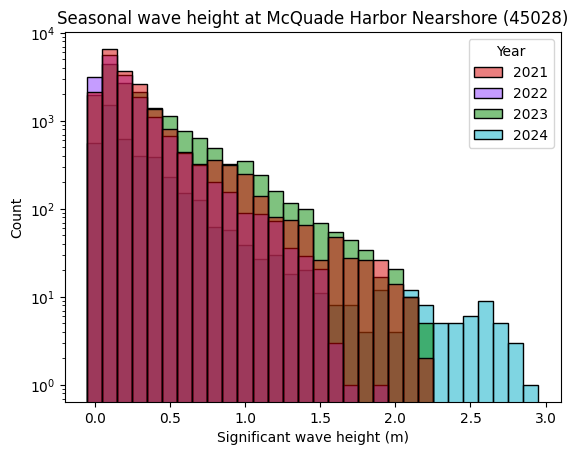

In [183]:
ax = sns.histplot(
    data=mcn_all,
    x="WVHT",
    binwidth=0.1,
    binrange=(-0.05, mcn_all.WVHT.max() + 0.05),
    hue="YY",
    multiple="layer",
    palette=sns.color_palette(cc.glasbey[:len(mcn_all["YY"].unique())]),
    #palette="tab10",
    #palette=["#ff0000", "#00ff00", "#0000ff", "#ffff00"],
    #palette="Set1",
)

ax.get_legend().set_title("Year")

plt.yscale('log')
plt.xlabel("Significant wave height (m)")
plt.ylabel("Count")
plt.title("Seasonal wave height at McQuade Harbor Nearshore (45028)")
plt.show()

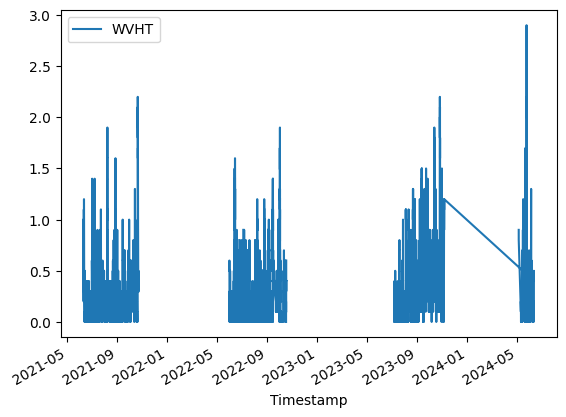

In [185]:
mcn_all.plot.line(x="Timestamp", y="WVHT")
plt.show()

In [74]:
mcn.Timestamp.min()

Timestamp('2024-05-05 16:00:00')

In [75]:
mcn.Timestamp.max()

Timestamp('2024-06-11 22:10:00')

In [76]:
mcn23.Timestamp.min()

Timestamp('2023-06-01 00:00:00')

In [77]:
mcn23.Timestamp.max()

Timestamp('2023-11-06 04:00:00')

In [187]:
vs = wls23.merge(mcn23, on="Timestamp", suffixes=("_wls", "_mcn"))

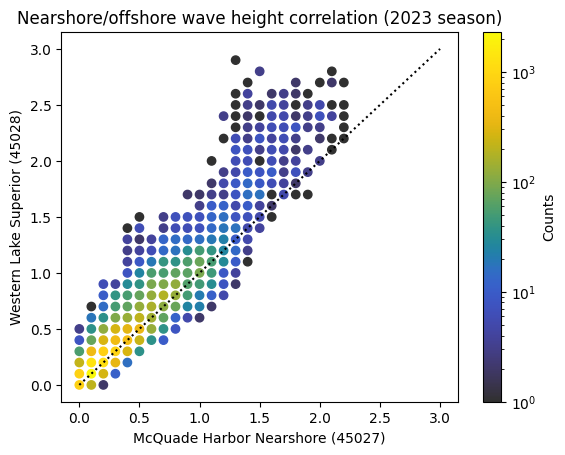

In [188]:
# Group by (x, y) pairs and count occurrences
grouped = vs.groupby(['WVHT_wls', 'WVHT_mcn']).size().reset_index(name='count')

# Plot scatter plot with sizes based on count
plt.scatter(grouped["WVHT_mcn"], grouped["WVHT_wls"], c=grouped["count"], cmap=cc.cm["CET_L20"], norm=LogNorm())
xl = np.linspace(0, 3)
yl = np.linspace(0, 3)
plt.plot(xl, yl, color="black", linestyle=":")
plt.xlabel("McQuade Harbor Nearshore (45027)")
plt.ylabel("Western Lake Superior (45028)")
plt.title("Nearshore/offshore wave height correlation (2023 season)")
cb = plt.colorbar()
cb.set_label("Counts")

plt.savefig('nearshore_vs_offshore.png', format='png', dpi=300, bbox_inches='tight')

plt.show()